**TER M1 - 2022 - Extraction de connaissances pour le domaine du Fact-checking**

*Encadrant* *: Konstantin Todorov* 

Auteurs : Benarab Hanane, Kimouche Aïcha, Terroufi Safae,

Le sujet de TER consiste a l'extraction de connaissances (véracité des claims, leurs auteurs, entités et événement liés) à partir du texte des articles publiés sur des sites de fact-checking en utilisant des méthodes de transfert learning et machine learning.

Un fichier excel sera créer pour extraire  et catégoriser les informations importantes.  
A chaque document est associé a sa véracité (True, False et Mixture). Le fichier des documents sera formaté dans un tableau cvs (une véracité par ligne).

# 0 - Mise en place de Google Drive et de fonctions

Le bout de code ci-dessous est optionnelle et permet de se connecter à notre google drive afin d'accéder aux données à traiter. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [2]:
import seaborn as sn
import matplotlib.pyplot as plt

def display_barplot(df, title, x, xlabel, y, ylabel, orient):

  
  # --- Colors
  colors = sn.color_palette('Reds_d', n_colors=len(df))

  # --- Barplot
  plt.figure(figsize=(15,5))
  g = sn.barplot(x=x, y=y,
             palette = colors,
             data=df, 
             orient=orient)

  # --- Annotations
  for p in g.patches:
    if orient == 'v':
      g.annotate('{:.2f}'.format(
          p.get_height()), 
          (p.get_x()+0.4, p.get_height()),
          ha='center', va='bottom',
          color= 'black')
    else:
      g.annotate('{:.2f}'.format(
          p.get_width()), 
          (p.get_width()+0.02, p.get_y()+0.4),
          ha='left', va='center',
          color='black')
    
  # --- Cosmetic
  plt.title(title, size=18)
  plt.xlabel(xlabel, size=15)
  plt.ylabel(ylabel, size=15)
  sn.despine()

def to_percent(n):
  """
  Use to increase the readability of the code
  @param n: (number) The number to convert
  @return n: (number) The number converted
  """
  return n*100

# 1 - Extraction des données 



In [3]:
import pandas as pd
import glob, os,io 
from google.colab import files 
  
  
uploaded = files.upload()
# Méthode locale
# df = pandas.concat( map( pandas.read_csv, glob.glob(os.path.join('', "./datasets/*.csv"))))

# Méthode drive
df = pd.read_csv(io.BytesIO(uploaded['claimss.csv'])) 
print(df)

Saving claimss.csv to claimss.csv
    rating_alternateName                                    claimReview_url  \
0                  False  https://fullfact.org/health/us-defence-data-co...   
1                Mixture  https://fullfact.org/health/pandemic-overspend...   
2                  False  https://fullfact.org/health/washington-post-lo...   
3                  False  https://fullfact.org/health/hiv-covid-vaccine-...   
4                Mixture  https://fullfact.org/online/pfizer-covid-vacci...   
..                   ...                                                ...   
494                 True  https://fullfact.org/economy/more-people-work-...   
495              Mixture  https://fullfact.org/economy/pound-fallen-sinc...   
496                 True  https://fullfact.org/economy/has-there-been-re...   
497              Mixture  https://fullfact.org/economy/are-british-busin...   
498                False  https://fullfact.org/economy/boris-johnson-mak...   

    creativeWork_

Analysons les données nulles présentes dans notre dataframe

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


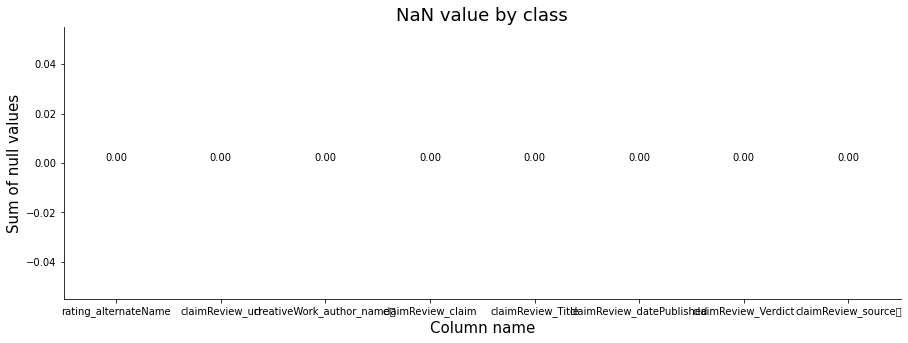

In [4]:
null_sums = [df[column].isnull().sum() for column in df.columns]

sums_df = pd.DataFrame({
    'Columns': df.columns, 
    'Null_sums': null_sums})

display_barplot(sums_df, 'NaN value by class', 
                'Columns', 'Column name', 
                'Null_sums', 'Sum of null values',
                'v')

# 2 - Prétraitement des données.

Le prétraitement des données consiste à modifier les valeurs des colonnes numériques du jeu de données pour utiliser une échelle commune, sans que les différences de plages de valeurs ne soient faussées et sans perte d'informations.

Nous avons choisis :

- Le Stemming -> Réduit les mots en leur radical ou un dérivé.

- La supression de caractères non ASCII -> Normalisation du texte en supprimant tous les caractères non ASCII.

- Passage en minuscule ->Normalisation du texte en supprimant tous les caractères non ASCII. Ce qui va env rien changer le sens du claim, il perdra juste en poids.


- Supression de la ponctuation -> le but des pre-traitements est de réduire le nombre de mots différents afin d’avoir une vitesse d’execution raisonnable. Nous avons estimé que les signes de ponctuation pouvaient être
ambivalents et qu’il n’etait pas forcément judicieux de les garder.

- Suppressions des stopwords ->, il existe un grand nombre de mots qui servent de lien a une grammaire syntaxique mais qui n’ont pas de signification propre (et donc pas de polarité). 
Nous les avons donc supprimes afin de gagner un grand temps de calcul sans perdre de précision sur le classifieur.



In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Le Stemming

In [7]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')


def stem_words(text):

  tokens = word_tokenize(text)
  return ' '.join([ stemmer.stem(word) for word in tokens ])


## Gestion du texte non ascii

En transformant notre fichier Excel en fichier CSV, certaines claims on des symbole bizarre. Pour y remédier, on normalise notre texte en supprimant tout les caractères non ascii. 

In [8]:
import unicodedata


def remove_non_ascii(words):

  new_words = []
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf8')
    
    if new_word:
      new_words.append(new_word)
      
  return new_words


## Lowering case

C'est la technique de prétraitement de texte la plus courante et la plus simple. Elle permet de convertir le texte en minuscule afin de réduire considérablement les tests à établir.

In [9]:


def to_lowercase(words):
 
  return [word.lower() for word in words]


## Single Character removal

Certaines phrases peuvent avoir deux mêmes mot d'affiler, cela n'apporte aucune information, les supprimer favoriseras donc la rapidité de notre apprentissage.

In [10]:


def remove_single_char(words):
  
  return [word for word in words if len(word) > 1]


## Removal of Punctuations

La ponctuation importe peu, elle est donc inutile à analyser, il convient donc de la retirer de notre jeu de donnés.


In [11]:
import re


def remove_punctuation(words):
  
  return [re.sub('[^\w\s]','', word) for word in words if re.sub('[^\w\s]','', word)]


## Numbers removal

De même que la ponctuation, les nombres sont peu informatifs et peuvent être supprimée. Nous aurions aussi pû les remplacer par du texte mais cela ajouterai des données supplémentaires "inutiles" à traiter pendant l'apprentissage.

In [12]:
import inflect


def remove_numbers(text):
  
  return ''.join(filter(lambda x: not x.isdigit(), text))


# --- On pourrait les remplacer si nécessaire avec cette fonction
# def replace_numbers(words):
#   p = inflect.engine()
#   return [p.number_to_words(word) if word.isdigit() else word for word in words]

# result = replace_numbers(words)
# print(''.join(result))

## Stop-word removal

Les mot tout le temps utilisé comme "the", "an", a... Ne sont pas important, on préféra alors les enlever.


In [13]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


def remove_stopwords(words):
  
  return [word for word in words if word not in stopwords]


## Clean text

Maintenant, on créera une fonction que l'on appelera pour nettoyer nos colonnes. Cette étape est très importante pour pouvoir ainsi appeler la fonction entière et donc nettoyer toute la colonne.

In [14]:


def normalize(words):
 
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = remove_single_char(words)
  words = remove_stopwords(words)
  return words

def clean_text(text):
 

  words = word_tokenize(text)
  words = normalize(words)
  return ' '.join(words)

def clean_dataframe_text(column_name):
  
  df[column_name] = df[column_name].apply(lambda x: clean_text(x))




Appliquons notre fonction sur les différentes données de notre dataframe.

In [15]:
df["claimReview_claim"] = df["claimReview_claim"].apply(stem_words)
clean_dataframe_text("claimReview_claim")

df["claimReview_Title"] = df["claimReview_Title"].apply(stem_words)
clean_dataframe_text("claimReview_Title")

clean_dataframe_text("creativeWork_author_name\t")
clean_dataframe_text("creativeWork_author_name\t")
clean_dataframe_text("rating_alternateName")
clean_dataframe_text("claimReview_Verdict")

# **N gramms**
---
Après avoir nettoyer nos données, on propose maintenant de separer le text en "sac de mot". Après cela, nous pouvons commencé à utiliser les classifieurs.



In [16]:
from sklearn.feature_extraction.text import CountVectorizer
# Generate n-grams upto n=1

x = df['claimReview_Verdict']

vectorizer_ng1 = CountVectorizer(ngram_range=(1, 1))
ng1 = vectorizer_ng1.fit_transform(x)
print("nn-grammes de tailles 1")
print(vectorizer_ng1.get_feature_names())



# Generate n-grams upto n=2
vectorizer_ng2 = CountVectorizer(ngram_range=(1, 2))
ng2 = vectorizer_ng2.fit_transform(x)
print("nn-grammes de tailles 1 et 2")
print(vectorizer_ng2.get_feature_names())

# Generate n-grams upto n=3
vectorizer_ng3 = CountVectorizer(ngram_range=(2, 3))
ng3 = vectorizer_ng3.fit_transform(x)
print("nn-grammes de tailles 2 et 3")
print(vectorizer_ng3.get_feature_names())

vectorizer_ng3 = CountVectorizer(ngram_range=(3, 3))
ng3 = vectorizer_ng3.fit_transform(x)
print("nn-grammes de tailles 3")
print(vectorizer_ng3.get_feature_names())
# Print the number of features for each model
#taille des modeles

print("nn-grammes de caractères de tailles 1 et 2 ")
vectorizer=CountVectorizer(analyzer='char',ngram_range=(1,2))
X=vectorizer.fit_transform(x)
print(vectorizer.get_feature_names())


nn-grammes de tailles 1
['02', '05', '09', '10', '100', '1000', '10000', '100000', '1015', '102', '109', '11', '12', '122', '125', '127', '128000', '13', '1300', '14', '140', '140000', '14185', '1421', '144', '15', '152000', '15p', '16', '1600', '1620', '165', '1664', '1674', '17500', '1799', '18', '180', '184000', '18477', '18515', '18th', '1918', '1961', '1964', '1971', '1980s', '19811995', '1991', '1996', '1997', '1am', '20', '200', '2000', '200001', '2000s', '20012005', '200203', '2003', '2004', '2006', '200607', '2008', '20082011', '2009', '200910', '2010', '201011', '2010s', '201112', '2012', '2013', '201314', '2014', '2015', '201516', '2016', '201617', '2017', '201718', '2018', '201819', '2019', '201920', '2020', '202021', '2021', '2022', '202223', '2025', '2060', '21', '210', '210000', '21650', '217000', '22', '23', '24', '24000', '245', '25', '250000', '26', '27', '28', '29', '293', '296', '30', '300', '30000', '309', '31', '31000', '312', '31855', '320000', '323', '33', '3330

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Transformation de données

On appelera la fonction ScikitLearn qui permettra d'effectuer les transformations et vectorisations.
Du coup, pour éviter tout problème de numérisation, les valeurs textuelles doivent être rendues numériques en utilisant une pondération fréquentielle (tf-idf, tf, ou autres).

In [17]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Définir la variable dépendante et indépendante comme x et y

#x = df['claimReview_Verdict']
#y = df["rating_alternateName"]

x = df['claimReview_Verdict']+['claimReview_source']+['claimReview_Title']+['claimReview_claim']+['claimReview_url']+['claimReview_datePublished']

y = df['rating_alternateName']

# Séparer le dataset au dessus en données d'entrainement et de test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
count_vectorizer = CountVectorizer(stop_words='english')

print('Train set:', x_train.shape)
print('Test set:', x_test.shape)




# Séparer le dataset au dessus en données d'entrainement et de test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
count_vectorizer = CountVectorizer(stop_words='english')


Train set: (349,)
Test set: (150,)


In [18]:
#convertire le texte en vecteur
from sklearn.feature_extraction.text import TfidfVectorizer
# Manipulation de données vectoriel
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

print(xv_train.shape)
print(xv_test.shape)

(349, 2089)
(150, 2089)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, svm

# appel de la fonction naive baye
t_NB = MultinomialNB()
DT= DecisionTreeClassifier()
LR = LogisticRegression()
SVM = svm.SVC(C=1.9, kernel='linear')

ng_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_ng = ng_vectorizer.fit_transform(x_train)
X_test_ng = ng_vectorizer.transform(x_test)
# tout les noms des classifieurs :
#t_NB = naive bayes classifieur
#DT =DecisionTreeClassifier
# LR = Logistic Regression


DT.fit(X_train_ng, y_train)
t_NB.fit(X_train_ng, y_train)
LR.fit(X_train_ng, y_train)
SVM.fit(X_train_ng, y_train)

# Prediction du claim pour un avis negatif ou positif
DT.predict(X_test_ng)
t_NB.predict(X_test_ng)
LR.predict(X_test_ng)
SVM.predict(X_test_ng)

# prediction 

accuracy1 = DT.score(X_test_ng, y_test)

accuracy2 = t_NB.score(X_test_ng, y_test)

accuracy3 = LR.score(X_test_ng, y_test)

accuracy4=SVM.score(X_test_ng,y_test)

print("l'accuracy du modele de l'arbre de decision en utilisant les parametre par defaut est de :  ", accuracy1)


print("l'accuracy du modele de l'arbre de Naive Bayes en utilisant les parametre par defaut est de :  ", accuracy2)

print("l'accuracy du modele de l'arbre de Logistic Regression en utilisant les parametre par defaut est de :  " , accuracy3)

print("l'accuracy du modele de SVM en utilisant les parametre par defaut est de :  " , accuracy4)



l'accuracy du modele de l'arbre de decision en utilisant les parametre par defaut est de :   0.6
l'accuracy du modele de l'arbre de Naive Bayes en utilisant les parametre par defaut est de :   0.6533333333333333
l'accuracy du modele de l'arbre de Logistic Regression en utilisant les parametre par defaut est de :   0.6533333333333333
l'accuracy du modele de SVM en utilisant les parametre par defaut est de :   0.6466666666666666


# 3 - Classification 


Maintenant que l'on a prétraité les données de notre dataframe nous pouvons commencer à utiliser des modèles. Les différents classifieur de Scikit-learn ne sont pas compatible avec du texte. Il faut donc re-processer les données déjà nettoyées.
Nous avons applique cette méthode sur les classifieurs suivants : LogisticRegression, KNeighbors, DecisionTree, GaussianNB et RandomForest.

Le choix de ces classifieurs a eté justifié par plusieurs raisons. En effet, une grande partie de ces classifieurs ont eté étudiés en cours, il était donc plus simple de les appréhender et d’améliorer leur performances. Ensuite, nous nous sommes beaucoup renseigne sur le site scikit-learn qui propose à la fois une explication pour le fonctionnement des classifieurs, mais aussi une explication pour leurs parametres. 

### Initialisation des fonctions

In [20]:
def display_confusion_matrix(confusion_matrix, labels=[]):
 
  sn.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.show()

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF_VECT = TfidfVectorizer()

def get_pipeline(classifier):
  
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('clf', classifier)])

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from time import time

SEED = 42

def apply_classifier(pipeline, data, target, disp=False, classifier_name=''):
  

  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  pipeline.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = pipeline.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy & confusion matrix
  accuracy = pipeline.score(X_test, y_test)
  conf = confusion_matrix(y_test, result)

  if disp:
    print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)
    print('\n[~] Rapport de classification: \n', classification_report(y_test, result))

  return accuracy

In [23]:
def display_pie(dataframe, column_name, title=''):
 
  dataframe[column_name].value_counts().plot(
      kind='pie', 
      figsize=(6,10),
      title=title, 
      fontsize=11, 
      legend=True,
      shadow=True,
      autopct='%1.1f%%'
  )
  plt.show()

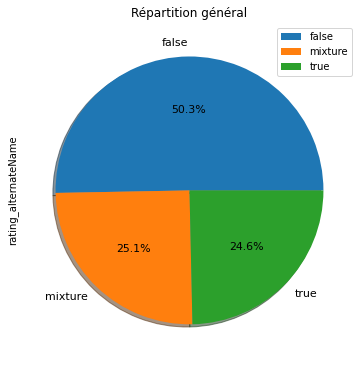

Statistique:
false      251
mixture    125
true       123
Name: rating_alternateName, dtype: int64


In [24]:
display_pie(df, 'rating_alternateName', 'Répartition général')

print("Statistique:")
print(df["rating_alternateName"].value_counts())

Classifier

### Un premier classifieur 
***Logistic Regression***

La régression logistique est une méthode d'analyse statistique permettant de prédire un résultat binaire, tel que oui ou non, sur la base d'observations antérieures d'un ensemble de données.

Un modèle de régression logistique prédit une variable de données dépendante en analysant la relation entre une ou plusieurs variables indépendantes existantes. Par exemple, une régression logistique pourrait être utilisée pour prédire si un candidat politique gagnera ou perdra une élection ou si un élève du secondaire sera admis ou non dans un collège particulier. Ces résultats binaires permettent des décisions directes entre deux alternatives.



In [25]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

LR = LogisticRegression(multi_class='multinomial',solver='lbfgs')
LR.fit(xv_train, y_train)
pred_lr = LR.predict(xv_test)
LR.score(xv_test, y_test)



print(confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr))
LR.score(xv_test, y_test)

    

[[74  3  3]
 [28  5  5]
 [ 7  1 24]]
              precision    recall  f1-score   support

       false       0.68      0.93      0.78        80
     mixture       0.56      0.13      0.21        38
        true       0.75      0.75      0.75        32

    accuracy                           0.69       150
   macro avg       0.66      0.60      0.58       150
weighted avg       0.66      0.69      0.63       150



0.6866666666666666

In [26]:
import matplotlib.pyplot as plt

def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf.pdf')  

    if title:
        plt.title(title)

## Naives-Bayes


Naive Bayes est conçu pour les documents texte. Multinomial Naive Bayes modélise expressément le mot cadre et modifie les estimations fondamentales pour le gérer. La probabilité de la phrase d'entrée avec l'étiquette est calculée et selon la probabilité atteinte, le résultat est formulé.

Exemple pratique Considérant un exemple pratique. L'entrée de l'utilisateur est une nouvelle "Le lavage minutieux des mains avec un savon ordinaire est efficace pour tuer le coronavirus (COVID-19) Le savon et l'eau seuls, lorsqu'ils sont utilisés conformément aux directives de lavage des mains de l'OMS, sont efficaces et faciles pour tuer le coronavirus" et veut vérifier si les nouvelles sont "True", "False" ou "Mixture".



[[78  1  1]
 [32  3  3]
 [10  0 22]]
0.6866666666666666


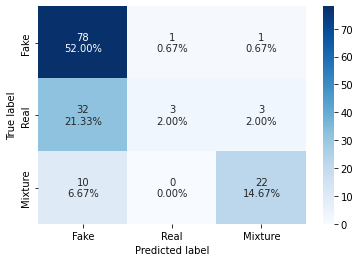

In [27]:
from sklearn import model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

# appel de la fonction naive baye
t_NB = MultinomialNB()

t_NB.fit(xv_train, y_train)
score=t_NB.score(xv_test, y_test)
#count_test = count_vectorizer.fit_transform(x_test)
pred = t_NB.predict(xv_test)



#score = accuracy_score(y_test, pred)
# calcule de la matrice de confusion : cm (faux positif, vrai negatif ...)
cm =confusion_matrix(y_test, pred)
# calcule de la matrice de confusion : cm (faux positif, vrai negatif ...)
#cm =confusion_matrix(xv_test, y_test)
print(cm)
print(score)



svm_cf_matrix = confusion_matrix(y_test, pred)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real','Mixture']

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')


## Arbre de decision

L'objectif de l'utilisation d'un arbre de décision est de créer un modèle de formation qui peut être utilisé pour prédire la classe ou la valeur de la variable cible en apprenant des règles de décision simples déduites de données antérieures (données de formation).

Dans les arbres de décision, pour prédire une étiquette de classe pour un enregistrement, nous partons de la racine de l'arbre. Nous comparons les valeurs de l'attribut racine avec l'attribut de l'enregistrement. Sur la base de la comparaison, nous suivons la branche correspondant à cette valeur et sautons au nœud suivant.

              precision    recall  f1-score   support

       false       0.68      0.68      0.68        80
     mixture       0.32      0.29      0.31        38
        true       0.67      0.75      0.71        32

    accuracy                           0.59       150
   macro avg       0.56      0.57      0.56       150
weighted avg       0.58      0.59      0.59       150

0.5933333333333334


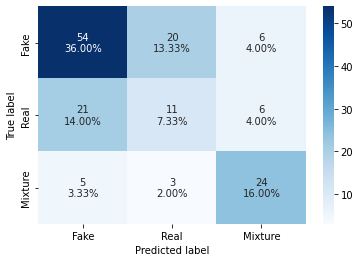

In [28]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)
pred_dt = DT.predict(xv_test)
DT.score(xv_test, y_test)


from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

print(classification_report(y_test, pred_dt))

sc = DT.score(xv_test,y_test)
print(sc)


svm_cf_matrix = confusion_matrix(y_test, pred_dt)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real','Mixture']

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')


##SVM

Les SVM sont bien adaptées à l'apprentissage dans les paramètres de classification de texte. L'idée centrale derrière les SVM est que cette approche tend à trouver une hypothèse h pour laquelle nous pouvons garantir l'erreur vraie la plus faible. La véritable erreur de h est la probabilité que h commette une erreur sur un exemple de test non vu et sélectionné au hasard. Les SVM sont des apprenants très universels, leur capacité à apprendre peut être indépendante de la dimensionnalité de l'espace des fonctionnalités.

Cette capacité de SVM à ne pas être sujet au surajustement est appréciée dans la détection de phrases dignes de vérification en tant que tâche de classification de texte, car le nombre total de caractéristiques extraites des phrases est considérablement élevé.

0.68


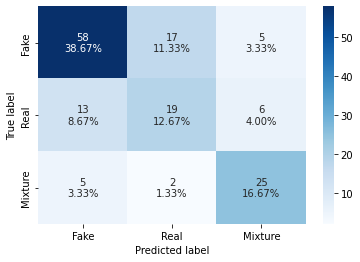

In [29]:
from sklearn import model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

SVM.fit(xv_train, y_train)
svm_predictions = SVM.predict(xv_test)
svm_cf_matrix = confusion_matrix(y_test, svm_predictions)

sc = SVM.score(xv_test,y_test)
print(sc)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real','Mixture']

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')


# 4 - Transformation des données

*On utilise Scikit Learn pour effectuer les transformations et vectorisations.Par la suite, les valeurs textuelles doivent être rendues numériques en utilisant une pondération fréquentielle (tf-idf, tf, ou autres).*

## *Learning Curves* 

Scikit-Learn offre un utilitaire pratique pour calculer de telles courbes d'apprentissage à partir de nos modèles. 

[ 31  62  94 125 157 188 219 251 282 314]


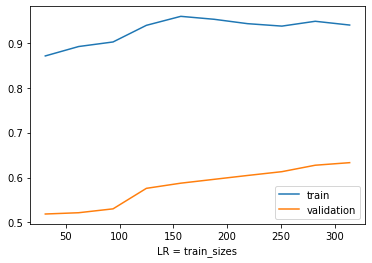

In [30]:
#Learning Curve avec Logistic Regression
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(LR, xv_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('LR = train_sizes')
plt.legend()



[ 31  62  94 125 157 188 219 251 282 314]


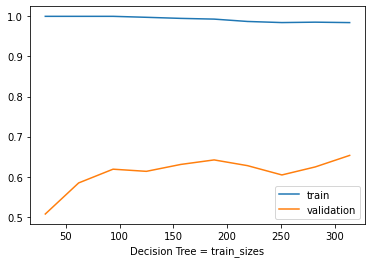

In [31]:
#Learning Curve avec Decision Tree
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(DT, xv_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('Decision Tree = train_sizes')
plt.legend()



[ 31  62  94 125 157 188 219 251 282 314]


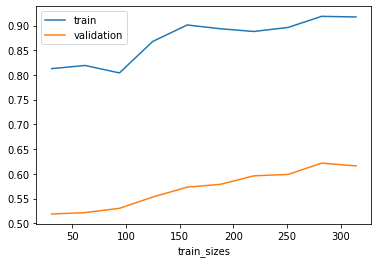

In [32]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()

from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(NB, xv_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=10)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

#6 - Cross Validation

  La cross validation est une méthode statistique qui permet d'évaluer les performances des modèles d'apprentissage automatique. Lorsqu'on entraîne un modèle sur des données étiquetées, on émet l'hypothèse qu'il doit également fonctionner sur de nouvelles données. 

[0.57142857 0.74285714 0.62857143 0.65714286 0.68571429 0.6
 0.51428571 0.65714286 0.62857143 0.58823529]
0.6273949579831932


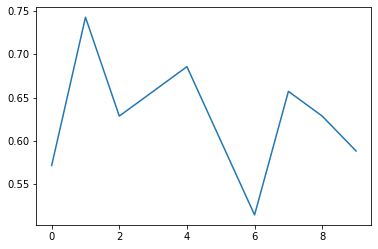

In [33]:
from sklearn.model_selection import KFold
model=DecisionTreeClassifier()
kfold_validation=KFold(10)
import numpy as np
from sklearn.model_selection import cross_val_score
results=cross_val_score(model,xv_train,y_train,cv=kfold_validation)
print(results)
print(np.mean(results))
plt.plot(results)

# 7 - Partie GridSearchCV

 Il nous permet de trouver le modele avec les meilleurs hyperparamètre en comparant les différentes performances de chaque conbinaison grace à la technique de crossvalidation.


In [34]:
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

TFIDF_VECT = TfidfVectorizer(min_df=0.001, ngram_range=(1,3))
VT = VarianceThreshold(threshold=0.0002)
SFM = SelectFromModel(LogisticRegression())

def get_pipeline_improved(classifier):
  
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', SFM),
                   ('clf', classifier)])

In [35]:
from sklearn.model_selection import GridSearchCV 

def init_grid_search(pipeline, params):

  return GridSearchCV(pipeline, params, scoring='accuracy', n_jobs=-1)

def apply_grid(grid, X_train, X_test, y_train, y_test, 
               disp=False, classifier_name=''):


  # --- Mise en place du GridSearch
  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  grid.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = grid.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy
  accuracy = accuracy_score(y_test, result)
  best_params = grid.best_params_
  print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
  print("[+] Meilleurs paramètres: ", best_params)
  
  # --- Confusion Matrix
  conf = confusion_matrix(y_test, result)
  if disp: 
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)

  # --- Report
  if disp: 
    print('\n[~] Rapport de classification: \n', classification_report(y_test, 
                                                                       result))
  return [accuracy, best_params]


def get_best_classifier(models, classifiers, params, data, target, disp):
  """
  Test all classifiers and return the best one.
  """
  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  best_model = ''
  best_accuracy = 0.0
  best_params = {}

  for model in models:
    pipeline = get_pipeline_improved(classifiers[model])
    grid = init_grid_search(pipeline, params[model])
    result = apply_grid(grid, X_train, X_test, y_train, y_test, disp, model)

    if (result[0] > best_accuracy):
      best_model = model
      best_accuracy = result[0]
      best_params = result[1]

  return [best_model, best_accuracy, best_params]

### Initialisation et mise en place

In [36]:
def concat_features(df, features):


  data = df[features]
  return data.apply(
      lambda x: ' '.join(x.dropna().astype(str)),
      axis=1
  )

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 42
models = ['RandomForest', 'KNeighbors', 'SGD', 'LogisticRegression']

classifiers = {
    models[0]: RandomForestClassifier(random_state=SEED, n_jobs=-1), 
    models[1]: KNeighborsClassifier(n_jobs=-1), 
    models[2]: SGDClassifier(random_state=SEED, n_jobs=-1),
    models[3]: LogisticRegression(random_state=SEED, n_jobs=-1)
}

params = {
  models[0]: {
      'clf__min_samples_split': [1, 2, 3],
      'clf__min_samples_leaf': [1, 2, 3],
      'clf__n_estimators': [100, 200, 300],
      'clf__criterion': ['gini', 'entropy']
  },
  models[1]: {
      'clf__n_neighbors': [5, 10], 
      'clf__weights': ['uniform', 'distance'], 
      'clf__leaf_size': [2, 5]
  },
  models[2]: {
      'clf__max_iter': [500, 1000, 2000],
      'clf__penalty': ['l1', 'l2', 'elasticnet']
  },
  models[3]: {
      'clf__max_iter': [1000, 2500, 5000],
      'clf__C': [1, 2], 
      'clf__solver' : ['lbfgs', 'liblinear']
  }
}

# --- Application du classifieur RandomForest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packa

[~] Fit réalisé en 110.022s
[~] Prédiction réalisée en 0.146s

[+] Accuracy: 64.667%
[+] Meilleurs paramètres:  {'clf__criterion': 'gini', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

[~] Matrice de confusion:


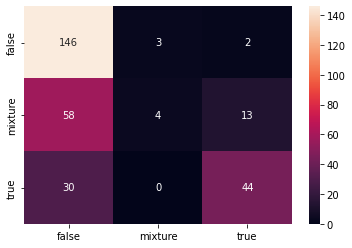


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.62      0.97      0.76       151
     mixture       0.57      0.05      0.10        75
        true       0.75      0.59      0.66        74

    accuracy                           0.65       300
   macro avg       0.65      0.54      0.51       300
weighted avg       0.64      0.65      0.57       300

# --- Application du classifieur KNeighbors
[~] Fit réalisé en 8.020s
[~] Prédiction réalisée en 0.170s

[+] Accuracy: 50.667%
[+] Meilleurs paramètres:  {'clf__leaf_size': 2, 'clf__n_neighbors': 5, 'clf__weights': 'uniform'}

[~] Matrice de confusion:


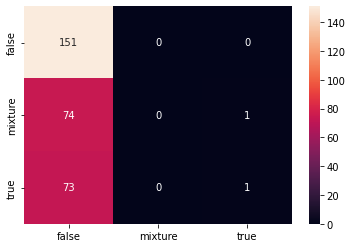

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.51      1.00      0.67       151
     mixture       0.00      0.00      0.00        75
        true       0.50      0.01      0.03        74

    accuracy                           0.51       300
   macro avg       0.34      0.34      0.23       300
weighted avg       0.38      0.51      0.35       300

# --- Application du classifieur SGD
[~] Fit réalisé en 6.825s
[~] Prédiction réalisée en 0.024s

[+] Accuracy: 63.667%
[+] Meilleurs paramètres:  {'clf__max_iter': 500, 'clf__penalty': 'l2'}

[~] Matrice de confusion:


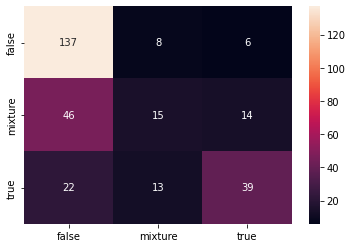


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.67      0.91      0.77       151
     mixture       0.42      0.20      0.27        75
        true       0.66      0.53      0.59        74

    accuracy                           0.64       300
   macro avg       0.58      0.54      0.54       300
weighted avg       0.60      0.64      0.60       300

# --- Application du classifieur LogisticRegression
[~] Fit réalisé en 8.360s
[~] Prédiction réalisée en 0.024s

[+] Accuracy: 61.667%
[+] Meilleurs paramètres:  {'clf__C': 2, 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}

[~] Matrice de confusion:


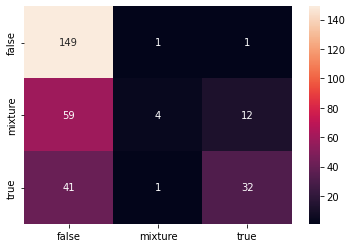


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.60      0.99      0.74       151
     mixture       0.67      0.05      0.10        75
        true       0.71      0.43      0.54        74

    accuracy                           0.62       300
   macro avg       0.66      0.49      0.46       300
weighted avg       0.64      0.62      0.53       300


--------------------------------------------------------------------- 
[+] Meilleur classifieur: RandomForest 
[+] Accuracy: 64.667% 
[+] Params:  {'clf__criterion': 'gini', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}


In [38]:
features = ['claimReview_claim', 'claimReview_Title', 'claimReview_datePublished', 'claimReview_Verdict']
data = concat_features(df, features)
target = df['rating_alternateName'].astype('string')

result = get_best_classifier(models, classifiers, params, data, target, True)

print("\n---------------------------------------------------------------------",
      "\n[+] Meilleur classifieur:", result[0], 
      "\n[+] Accuracy: %0.3f%%" % to_percent(result[1]),
      "\n[+] Params: ", result[2])

### Sauvegarde

Sauvegardons nos deux meilleurs résultat pour éviter de réexécuter notre benchmark à chaque fois. Nous conservons les deux premiers au cas ou par la suite nous souhaiterions encore une fois les comparer.

In [39]:
# --- Save the best accuracy found
best_clf_accuracy = result[1]

In [40]:
# --- Best classifier
best_clf_name = "RandomForest"
best_clf = classifiers[best_clf_name]

params = {'criterion': 'entropy', 
          'min_samples_leaf': 1, 'min_samples_split': 3, 
          'n_estimators': 300}
best_clf.set_params(**params)

best_clf_pipeline = get_pipeline_improved(best_clf)
print("[+] Best classifier: \n", best_clf)

# --- Second best classifier
LR_name = "LogisticRegression"
LR_clf = classifiers[LR_name]

params = {'C': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
LR_clf.set_params(**params)

LR_pipeline = get_pipeline_improved(LR_clf)
print("[+] Second best classifier: \n", LR_clf)

[+] Best classifier: 
 RandomForestClassifier(criterion='entropy', min_samples_split=3,
                       n_estimators=300, n_jobs=-1, random_state=42)
[+] Second best classifier: 
 LogisticRegression(C=2, max_iter=1000, n_jobs=-1, random_state=42)


### UpSlamping

La méthode de UpSlamping (ou sur-échantillonnage) est l'inverse du DownSlampling, son processus à pour but d'augmenter la fréquence d'échantillonnage.

Ce qui veut dire qu'avec **True vs Fals**e, nous devrons donc augmenter le nombre de classe **True**, pour s'ajuster au nombre de classe **False**. 

A l'inverse de la perte de données, c'est les données aléatoires qui sont créent pendant l'opération qui peuvent poser problème et fausser notre prédiction.

In [41]:
nb_false, nb_mixture, nb_true = df["rating_alternateName"].value_counts()

df_false = df[df['rating_alternateName'] == "false"]
df_mixture = df[df['rating_alternateName'] == "mixture"]
df_true = df[df['rating_alternateName'] == "true"]

Répartition après Upslamping:
false    251
true     251
Name: rating_alternateName, dtype: int64 



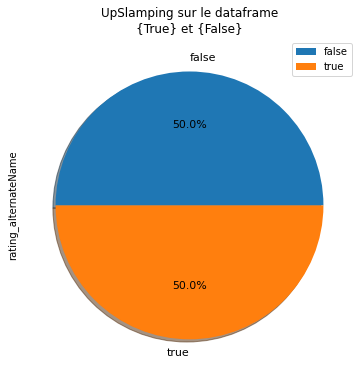

In [42]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TF_UP = pd.concat([df_false, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TF_UP["rating_alternateName"].value_counts(), '\n')
display_pie(df_TF_UP, 'rating_alternateName', 'UpSlamping sur le dataframe\n{True} et {False}')

Le jeu de donnée à était parfaitement équilibrée par rapport à notre classe **False**, testons notre classifieur sur ce nouveau jeu de donnée équilibrée.

# --- Application du classifieur 
[~] Fit réalisé en 0.027s
[~] Prédiction réalisée en 0.014s

[+] Accuracy: 85.430%

[~] Matrice de confusion:


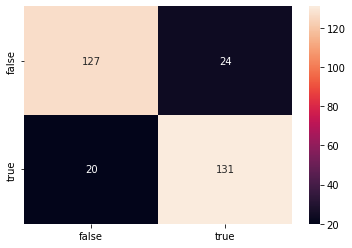


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.86      0.84      0.85       151
        true       0.85      0.87      0.86       151

    accuracy                           0.85       302
   macro avg       0.85      0.85      0.85       302
weighted avg       0.85      0.85      0.85       302



In [43]:
data = df_TF_UP['claimReview_claim']
target = df_TF_UP['rating_alternateName'].astype('string')
classifier = LogisticRegression(n_jobs=-1)
pipeline = get_pipeline(classifier)

after_upsampling = apply_classifier(pipeline, data, target, True)

# --- Application du classifieur 
[~] Fit réalisé en 0.037s
[~] Prédiction réalisée en 0.009s

[+] Accuracy: 73.179%

[~] Matrice de confusion:


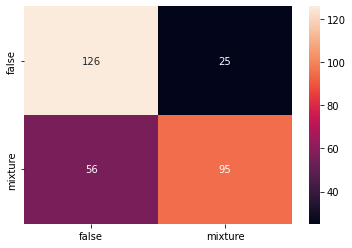


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.69      0.83      0.76       151
     mixture       0.79      0.63      0.70       151

    accuracy                           0.73       302
   macro avg       0.74      0.73      0.73       302
weighted avg       0.74      0.73      0.73       302



In [44]:
#pareil avec mixture
df_mixture_up = df_mixture.sample(nb_false, replace=True)
df_FM_UP = pd.concat([df_false, df_mixture_up], axis=0)
data = df_FM_UP['claimReview_claim']
target = df_FM_UP['rating_alternateName'].astype('string')

after_upsampling = apply_classifier(pipeline, data, target, True)


### Upsampling True vs False vs Mixture

Répartition après Upslamping:
false      251
mixture    251
true       251
Name: rating_alternateName, dtype: int64 



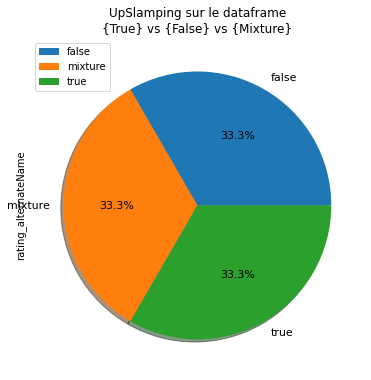

In [45]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TFM_UP = pd.concat([df_false, df_mixture_up, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TFM_UP["rating_alternateName"].value_counts(), '\n')
display_pie(df_TFM_UP, 'rating_alternateName', 'UpSlamping sur le dataframe\n{True} vs {False} vs {Mixture}')

# 4 - Optimisation

Pour améliorer notre précision nous pouvons ajouter de nouvelles features lors de l'apprentissage, mais il faut les choisirs avec soin. En effet, de nouvelles données inutiles ajouterait du bruit à l'estimation, de même si l'on ajoute des informations redondante. Nous pouvons ainsi économiser du temps et/ou de l'argent en ne mesurant pas ces prédicteurs.

### Initialisation et mise en place

In [77]:
def concat_features(df, features):


  data = df[features]
  return data.apply(
      lambda x: ' '.join(x.dropna().astype(str)),
      axis=1
  )

### Remove constant and select best features

Nous pouvons améliorer les features a faible variances en supprimant toutes les features inférieure à une certaines valeurs données. Après cette étape de nettoyage on peut utiliser un selecteur de feature qui choisis, ici, la moitié des features en fonction de leur poids.

In [78]:
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

TFIDF_VECT = TfidfVectorizer(min_df=0.001, ngram_range=(1,3))
VT = VarianceThreshold(threshold=0.0002)
SFM = SelectFromModel(LogisticRegression())

def get_pipeline_improved(classifier):
  
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', SFM),
                   ('clf', classifier)])

# --- Application du classifieur 
[~] Fit réalisé en 0.398s
[~] Prédiction réalisée en 0.040s

[+] Accuracy: 99.669%

[~] Matrice de confusion:


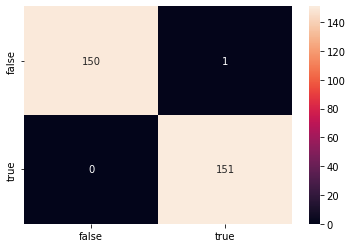


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       1.00      0.99      1.00       151
        true       0.99      1.00      1.00       151

    accuracy                           1.00       302
   macro avg       1.00      1.00      1.00       302
weighted avg       1.00      1.00      1.00       302

[+] Feature selection accuracy: 99.67%


In [79]:
from sklearn.ensemble import RandomForestClassifier


RF_pipeline = get_pipeline_improved(RandomForestClassifier())
feature_selection_accuracy = apply_classifier(RF_pipeline, data, target, True)

print("[+] Feature selection accuracy: %0.2f%%" 
      %to_percent(feature_selection_accuracy))

Le temps de calcul à était augmentée de 4s dû à ce nouveau classifieur mais nous gagnons $\approx4\%$ de précision ce qui n'est pas négligeable. 

## Ajouts de données additionnel

La date n'est pas un élément utile, composé uniquement de chiffre elle n'apportera aucune information et ne sera que du bruit dans notre apprentissage. 

In [80]:
unwanted = ['claimReview_datePublished']

Les liens relatifs et absolus, respectivement *sourceURL* et *link* sont aussi des sources de bruits qui sont généralement supprimé lors du prétraitement du texte, donc les ajouter n'est pas correcte. 

In [81]:
unwanted.extend(['claimReview_url', 'claimReview_source\t'])

Le colonne *Language* est inutile dans le sens ou les données qui la composent est redondante. Composé entièrement de la même valeur, ici "English". Les données comme celles-ci sont inutiles pour améliorer les prédictions.

In [82]:
_df = df_TF_UP.drop(unwanted, axis=1)
_df.head()

,rating_alternateName,creativeWork_author_name\t,claimReview_claim,claimReview_Title,claimReview_Verdict
0,false,abbas panjwani,data us militari show sharp rise incid various...,us defenc data show rise diseas 2021 produc error,data supporting claim flawed withdrawn officials
2,false,abbas panjwani,least 50 peopl surviv covid19 debilit health i...,washington post overst preval long covid,far high various estimates prevalence long cov...
3,false,abbas panjwani,bbc said hiv covid19 vaccin,potenti covid19 vaccin use hiv protein never roll,bbc talking vaccine trialled never rolled cont...
5,false,grace rahman,itv news articl headlin shake duvet vigor make...,warn vigor duvetshak rais risk heart attack fake,screenshot showing doctored article exists
7,false,daniella de block golding,video show four leg monster climb build russia,video monster climb build appear hoax,one videos previously reported hoax created gr...



Comparons le bénéfices de précision obtenus lors de l'ajout d'une unique feature, avec notre texte principal, nous pourrons ainsi déterminer des conclusions sur notre méthodes de choix.

In [83]:
features = list(_df.columns)
accuracies = []

for feature in features[1:]:
  actual_features = ['claimReview_claim', feature]
  data = concat_features(_df, actual_features)
  accuracy = apply_classifier(RF_pipeline, data, target)
  print("Features:", actual_features, 
        "| Accuracy: %0.2f%%" % to_percent(accuracy))
  accuracies.append(accuracy)

Features: ['claimReview_claim', 'creativeWork_author_name\t'] | Accuracy: 85.76%
Features: ['claimReview_claim', 'claimReview_claim'] | Accuracy: 87.09%
Features: ['claimReview_claim', 'claimReview_Title'] | Accuracy: 84.77%
Features: ['claimReview_claim', 'claimReview_Verdict'] | Accuracy: 93.05%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


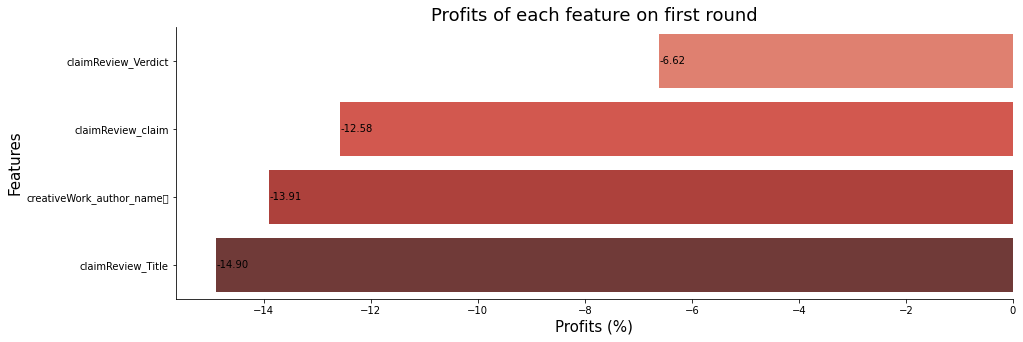

In [84]:
profits = [to_percent(accuracy - feature_selection_accuracy) for accuracy in accuracies]

# mise à l'échelle si nécessaire
# min = np.min(profits)
# if (min < 0): profits = list(map(lambda x: x + abs(min), profits))

df_profits = pd.DataFrame({
    'features': features[1:], 
    'profits': profits})
df_profits = df_profits.sort_values(by='profits', ascending=False)

display_barplot(df_profits, 
                "Profits of each feature on first round", 
                'profits', 
                'Profits (%)',
                'features', 
                'Features', 
                'h')



```
# Ce texte est au format code
```

Toutes les données sembles utiles à ajouter. Sauf named_entities_article qui est très faible et author car on le rappelle celui-ci appartient déjà à named_entities_claim

In [85]:
features = ['claimReview_claim', 'claimReview_Title', 'rating_alternateName' ,'claimReview_Verdict']

### Précision avec les nouvelles données

In [86]:
df_TFM_UP = pd.concat([df_false, df_true_up,df_mixture_up], axis=0)

unwanted = ['claimReview_url']
unwanted.extend(['claimReview_source\t'])



_df = df_TFM_UP.drop(unwanted, axis=1)
_df.head()



,rating_alternateName,creativeWork_author_name\t,claimReview_claim,claimReview_Title,claimReview_datePublished,claimReview_Verdict
0,false,abbas panjwani,data us militari show sharp rise incid various...,us defenc data show rise diseas 2021 produc error,2/18/2022,data supporting claim flawed withdrawn officials
2,false,abbas panjwani,least 50 peopl surviv covid19 debilit health i...,washington post overst preval long covid,2/16/2022,far high various estimates prevalence long cov...
3,false,abbas panjwani,bbc said hiv covid19 vaccin,potenti covid19 vaccin use hiv protein never roll,2/16/2022,bbc talking vaccine trialled never rolled cont...
5,false,grace rahman,itv news articl headlin shake duvet vigor make...,warn vigor duvetshak rais risk heart attack fake,2/16/2022,screenshot showing doctored article exists
7,false,daniella de block golding,video show four leg monster climb build russia,video monster climb build appear hoax,12/15/2021,one videos previously reported hoax created gr...


Répartition après Upslamping:
false      251
mixture    251
true       251
Name: rating_alternateName, dtype: int64 



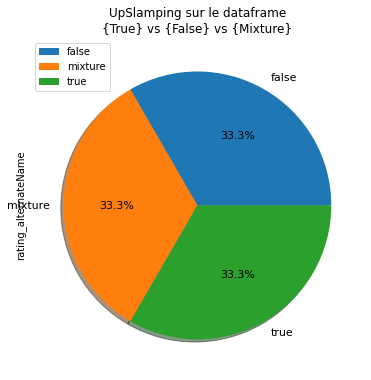

# --- Application du classifieur 
[~] Fit réalisé en 0.090s
[~] Prédiction réalisée en 0.014s

[+] Accuracy: 69.912%

[~] Matrice de confusion:


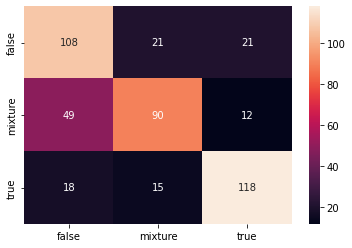


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.62      0.72      0.66       150
     mixture       0.71      0.60      0.65       151
        true       0.78      0.78      0.78       151

    accuracy                           0.70       452
   macro avg       0.70      0.70      0.70       452
weighted avg       0.70      0.70      0.70       452



In [87]:
df_TFM_UP = pd.concat([df_false, df_mixture_up, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TFM_UP["rating_alternateName"].value_counts(), '\n')
display_pie(df_TFM_UP, 'rating_alternateName', 'UpSlamping sur le dataframe\n{True} vs {False} vs {Mixture}')

#pareil avec mixture
data = df_TFM_UP['claimReview_claim']
target = df_TFM_UP['rating_alternateName'].astype('string')

after_upsampling = apply_classifier(pipeline, data, target, True)

Avec toutes les données nous obtenons un score avoisinant les $80.4\%$ soit $\approx5\%$ de plus que notre score précédent.

### Initialisation des fonctions et des classifieurs

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
SEED = 42
models = ['RandomForest', 'KNeighbors', 'SGD', 'LogisticRegression']

classifiers = {
    models[0]: RandomForestClassifier(random_state=SEED, n_jobs=-1), 
    models[1]: KNeighborsClassifier(n_jobs=-1), 
    models[2]: SGDClassifier(random_state=SEED, n_jobs=-1),
    models[3]: LogisticRegression(random_state=SEED, n_jobs=-1)
}

params = {
  models[0]: {
      'clf__min_samples_split': [1, 2, 3],
      'clf__min_samples_leaf': [1, 2, 3],
      'clf__n_estimators': [100, 200, 300],
      'clf__criterion': ['gini', 'entropy']
  },
  models[1]: {
      'clf__n_neighbors': [5, 10], 
      'clf__weights': ['uniform', 'distance'], 
      'clf__leaf_size': [2, 5]
  },
  models[2]: {
      'clf__max_iter': [500, 1000, 2000],
      'clf__penalty': ['l1', 'l2', 'elasticnet']
  },
  models[3]: {
      'clf__max_iter': [1000, 2500, 5000],
      'clf__C': [1, 2], 
      'clf__solver' : ['lbfgs', 'liblinear']
  }
}

Nos classifieurs et leur différents paramètres sont en place, il ne nous reste plus qu'à ajouter une fonction permettant d'itérer sur nos différents modèles pour les tester un a un et renvoyer le meilleur d'entre eux.

In [89]:
from sklearn.model_selection import GridSearchCV 

def init_grid_search(pipeline, params):

  return GridSearchCV(pipeline, params, scoring='accuracy', n_jobs=-1)

def apply_grid(grid, X_train, X_test, y_train, y_test, 
               disp=False, classifier_name=''):


  # --- Mise en place du GridSearch
  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  grid.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = grid.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy
  accuracy = accuracy_score(y_test, result)
  best_params = grid.best_params_
  print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
  print("[+] Meilleurs paramètres: ", best_params)
  
  # --- Confusion Matrix
  conf = confusion_matrix(y_test, result)
  if disp: 
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)

  # --- Report
  if disp: 
    print('\n[~] Rapport de classification: \n', classification_report(y_test, 
                                                                       result))
  return [accuracy, best_params]


def get_best_classifier(models, classifiers, params, data, target, disp):
  """
  Test all classifiers and return the best one.
  """
  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  best_model = ''
  best_accuracy = 0.0
  best_params = {}

  for model in models:
    pipeline = get_pipeline_improved(classifiers[model])
    grid = init_grid_search(pipeline, params[model])
    result = apply_grid(grid, X_train, X_test, y_train, y_test, disp, model)

    if (result[0] > best_accuracy):
      best_model = model
      best_accuracy = result[0]
      best_params = result[1]

  return [best_model, best_accuracy, best_params]

### Exécution (Temps de compilation environs 12 minutes)

Tout est prêt nous pouvons démarrer le benchmark

# --- Application du classifieur RandomForest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packa

[~] Fit réalisé en 107.286s
[~] Prédiction réalisée en 0.242s

[+] Accuracy: 99.558%
[+] Meilleurs paramètres:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

[~] Matrice de confusion:


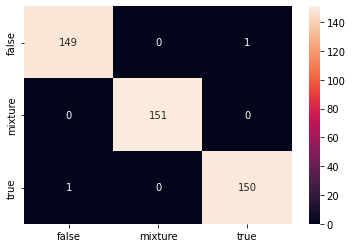


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.99      0.99      0.99       150
     mixture       1.00      1.00      1.00       151
        true       0.99      0.99      0.99       151

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

# --- Application du classifieur KNeighbors
[~] Fit réalisé en 7.407s
[~] Prédiction réalisée en 0.228s

[+] Accuracy: 75.221%
[+] Meilleurs paramètres:  {'clf__leaf_size': 2, 'clf__n_neighbors': 10, 'clf__weights': 'distance'}

[~] Matrice de confusion:


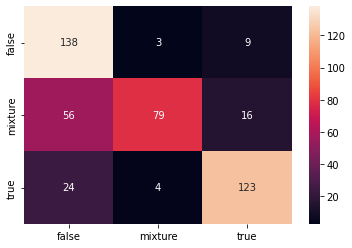


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.63      0.92      0.75       150
     mixture       0.92      0.52      0.67       151
        true       0.83      0.81      0.82       151

    accuracy                           0.75       452
   macro avg       0.79      0.75      0.75       452
weighted avg       0.79      0.75      0.75       452

# --- Application du classifieur SGD
[~] Fit réalisé en 14.729s
[~] Prédiction réalisée en 0.067s

[+] Accuracy: 96.903%
[+] Meilleurs paramètres:  {'clf__max_iter': 500, 'clf__penalty': 'l1'}

[~] Matrice de confusion:


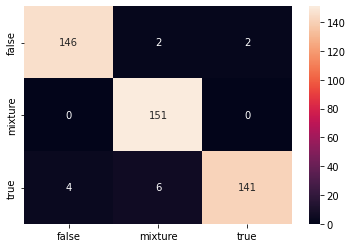


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.97      0.97      0.97       150
     mixture       0.95      1.00      0.97       151
        true       0.99      0.93      0.96       151

    accuracy                           0.97       452
   macro avg       0.97      0.97      0.97       452
weighted avg       0.97      0.97      0.97       452

# --- Application du classifieur LogisticRegression
[~] Fit réalisé en 16.440s
[~] Prédiction réalisée en 0.047s

[+] Accuracy: 87.832%
[+] Meilleurs paramètres:  {'clf__C': 2, 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}

[~] Matrice de confusion:


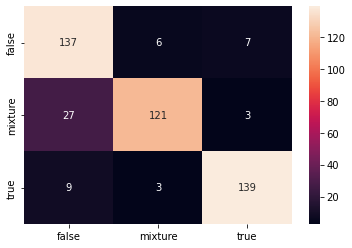


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       0.79      0.91      0.85       150
     mixture       0.93      0.80      0.86       151
        true       0.93      0.92      0.93       151

    accuracy                           0.88       452
   macro avg       0.89      0.88      0.88       452
weighted avg       0.89      0.88      0.88       452


--------------------------------------------------------------------- 
[+] Meilleur classifieur: RandomForest 
[+] Accuracy: 99.558% 
[+] Params:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}


In [90]:
data = concat_features(_df, features)
target = _df['rating_alternateName'].astype('string')

result = get_best_classifier(models, classifiers, params, data, target, True)

print("\n---------------------------------------------------------------------",
      "\n[+] Meilleur classifieur:", result[0], 
      "\n[+] Accuracy: %0.3f%%" % to_percent(result[1]),
      "\n[+] Params: ", result[2])

Le classifier RandomForest (RF) qui arrive en tête avec un taux de précision avoisinnant les $\approx80.2\%$, talonné par LogisticRegression (LR) avec près de $\approx78.9\%$. Nous avons donc encore réussi à améliorer notre modèles.

### Sauvegarde

Sauvegardons nos deux meilleurs résultat pour éviter de réexécuter notre benchmark à chaque fois. 

In [91]:
# --- Save the best accuracy found
best_clf_accuracy = result[1]

In [92]:
# --- Best classifier
best_clf_name = "RandomForest"
best_clf = classifiers[best_clf_name]

params = {'criterion': 'entropy', 
          'min_samples_leaf': 1, 'min_samples_split': 3, 
          'n_estimators': 300}
best_clf.set_params(**params)

best_clf_pipeline = get_pipeline_improved(best_clf)
print("[+] Best classifier: \n", best_clf)

# --- Second best classifier
LR_name = "LogisticRegression"
LR_clf = classifiers[LR_name]

params = {'C': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
LR_clf.set_params(**params)

LR_pipeline = get_pipeline_improved(LR_clf)
print("[+] Second best classifier: \n", LR_clf)

[+] Best classifier: 
 RandomForestClassifier(criterion='entropy', min_samples_split=3,
                       n_estimators=300, n_jobs=-1, random_state=42)
[+] Second best classifier: 
 LogisticRegression(C=2, max_iter=1000, n_jobs=-1, random_state=42)


### Conclusion

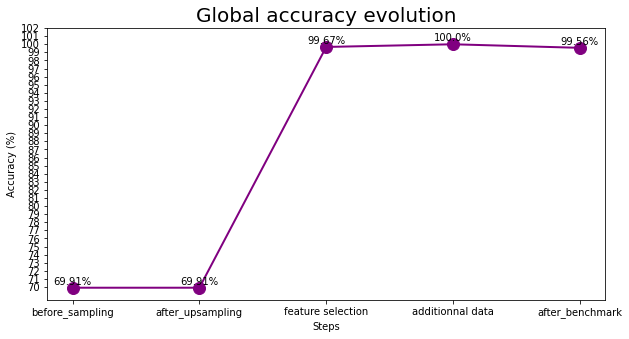

In [93]:
x = ["before_sampling", "after_upsampling", 
     "feature selection", 
     "additionnal data",
     "after_benchmark"]

y = [to_percent(before_sampling), to_percent(after_upsampling),
     to_percent(feature_selection_accuracy),
     to_percent(TF_accuracy),
     to_percent(best_clf_accuracy)]
y = list(map(lambda x: round(x, 2), y))

# --- Plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(x, y,
         marker='o', markersize=12,
         linewidth=2, color='purple')

# --- Cosmetic
plt.title(label='Global accuracy evolution', fontsize=20)
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')

# --- Labels on marker
for a,b in zip(x, y): 
  plt.text(a, b+0.4, str(b)+"%", ha="center")

# --- Ticks
yticks_min = round(np.amin(y))
yticks_max = round(np.amax(y))+3
plt.yticks(np.arange(yticks_min, yticks_max, 1))

plt.show()

In [94]:
print("Bénéfices global: +%0.2f%%" %to_percent(best_clf_accuracy - before_sampling))

Bénéfices global: +29.65%


## True vs False vs Mixture

In [95]:
_df = df_TFM_UP.drop(unwanted, axis=1)
_df.head()

,rating_alternateName,creativeWork_author_name\t,claimReview_claim,claimReview_Title,claimReview_datePublished,claimReview_Verdict
0,false,abbas panjwani,data us militari show sharp rise incid various...,us defenc data show rise diseas 2021 produc error,2/18/2022,data supporting claim flawed withdrawn officials
2,false,abbas panjwani,least 50 peopl surviv covid19 debilit health i...,washington post overst preval long covid,2/16/2022,far high various estimates prevalence long cov...
3,false,abbas panjwani,bbc said hiv covid19 vaccin,potenti covid19 vaccin use hiv protein never roll,2/16/2022,bbc talking vaccine trialled never rolled cont...
5,false,grace rahman,itv news articl headlin shake duvet vigor make...,warn vigor duvetshak rais risk heart attack fake,2/16/2022,screenshot showing doctored article exists
7,false,daniella de block golding,video show four leg monster climb build russia,video monster climb build appear hoax,12/15/2021,one videos previously reported hoax created gr...


In [96]:
def get_pipeline_improved_bis(classifier):
  
  _SFM = SelectFromModel(best_clf)
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', _SFM),
                   ('clf', classifier)])

In [104]:
def display_unique_data_profits(df, classifier, features, target):
  
  witness_acc = apply_classifier(classifier, df['claimReview_claim'], target)
  print("Witness accuracy: %0.2f%%" % to_percent(witness_acc))

  accuracies = []

  # --- get profits
  for feature in features:
    actual_features = ['claimReview_claim', feature]
    data = concat_features(_df, actual_features)
    accuracy = apply_classifier(classifier, data, target)
    print("Features:", actual_features, 
          "| Accuracy: %0.2f%%" % to_percent(accuracy))
    accuracies.append(accuracy)
    
  profits = [to_percent(accuracy - witness_acc) for accuracy in accuracies]
  
  # --- store and order in a dataframe
  df_profits = pd.DataFrame({
    'features': features, 
    'profits': profits})
  df_profits = df_profits.sort_values(by='profits', ascending=False)

  # --- display them
  display_barplot(df_profits, 
                  "Profits of each feature on first round", 
                  'profits', 
                  'Profits (%)',
                  'features', 
                  'Features', 
                  'h')

Witness accuracy: 69.91%
Features: ['claimReview_claim', 'rating_alternateName'] | Accuracy: 100.00%
Features: ['claimReview_claim', 'creativeWork_author_name\t'] | Accuracy: 71.90%
Features: ['claimReview_claim', 'claimReview_claim'] | Accuracy: 70.13%
Features: ['claimReview_claim', 'claimReview_Title'] | Accuracy: 71.24%
Features: ['claimReview_claim', 'claimReview_datePublished'] | Accuracy: 72.79%
Features: ['claimReview_claim', 'claimReview_Verdict'] | Accuracy: 74.34%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


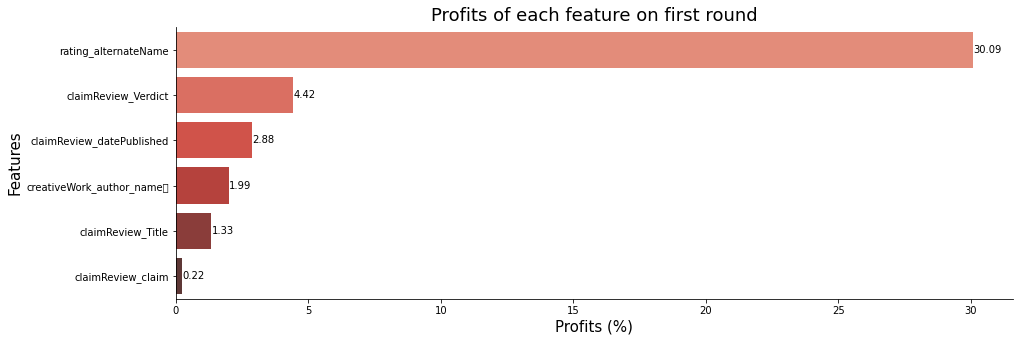

In [107]:
additionnal_features = list(_df.columns)
_pipeline = get_pipeline_improved_bis(best_clf)
target = _df['rating_alternateName'].astype('string')
display_unique_data_profits(_df, _pipeline, additionnal_features, target)

# --- Application du classifieur 
[~] Fit réalisé en 1.869s
[~] Prédiction réalisée en 0.449s

[+] Accuracy: 100.000%

[~] Matrice de confusion:


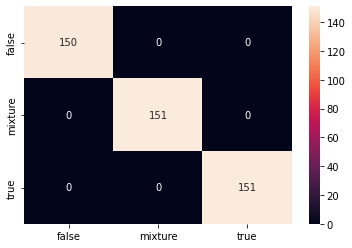


[~] Rapport de classification: 
               precision    recall  f1-score   support

       false       1.00      1.00      1.00       150
     mixture       1.00      1.00      1.00       151
        true       1.00      1.00      1.00       151

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452



In [106]:
features = ['rating_alternateName', 'creativeWork_author_name\t', 'claimReview_claim', 'claimReview_Title']
#					
data = concat_features(_df, features)
TFM_accuracy = apply_classifier(_pipeline, data, target, True)